In [1]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pinn.lib import SchrodingerData, SchrodingerModel, get_loss, Util, get_loss
from pinn.train_bayesian_mcmc import train

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os

os.makedirs("Data", exist_ok=True)

import requests

url = "https://github.com/maziarraissi/PINNs/raw/master/main/Data/NLS.mat"
r = requests.get(url)

with open("Data/NLS.mat", "wb") as f:
    f.write(r.content)

print("Downloaded NLS.mat to Data/NLS.mat")

Downloaded NLS.mat to Data/NLS.mat


In [4]:
data = scipy.io.loadmat('Data/NLS.mat')

t_np = data['tt'].flatten()[:,None]
x_np = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

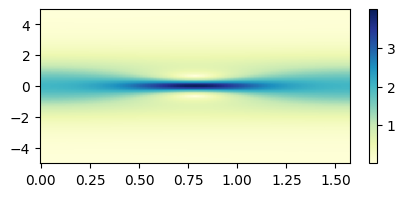

In [5]:
T_np, X_np = np.meshgrid(t_np.squeeze(), x_np.squeeze())

plt.figure(figsize=(5,2))
plt.pcolormesh(T_np, X_np, np.abs(Exact), cmap="YlGnBu")
plt.colorbar()
plt.show()

In [6]:
util = Util()
schrodinger_data = SchrodingerData(util,
                                   Exact,
                                   x_np,
                                   n_data=50,
                                   n_boundary=50,
                                   n_collocation=20000,
                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5]
                                  )

In [9]:
epochs = 100
schrodinger_model = SchrodingerModel(n_input=2,n_layer=3, n_out=2,                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5])
optimizer = torch.optim.Adam(schrodinger_model.parameters())
schrodinger_model.to(device)

SchrodingerModel(
  (first): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
  )
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
  )
  (last): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
train(wandb_run=None, 
      beta_factor=0.0006572, 
      lr=0.0000916, 
      sigma_w=2, 
      epochs=epochs, 
      burn_in=30000
)

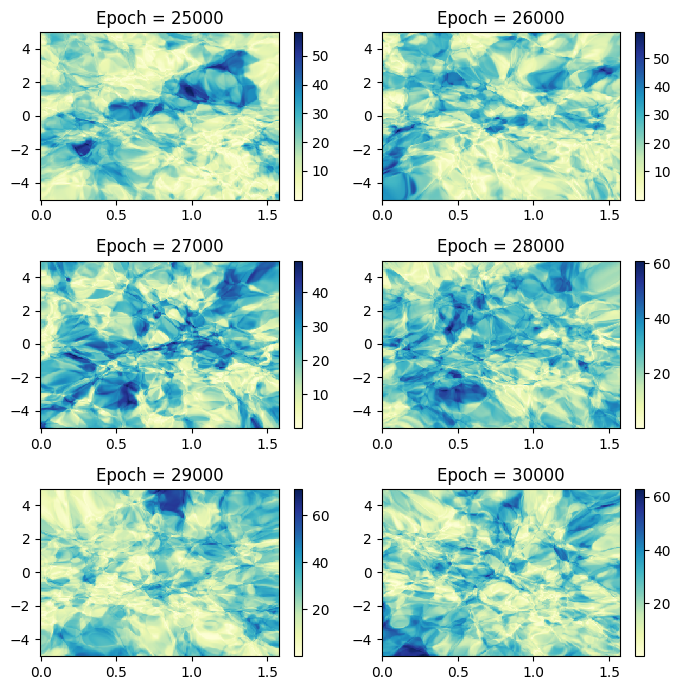

In [12]:
plt.figure(figsize=(7,7))
start = 25000
params = []
for i in range(6):
    epoch = start + i * 1000
    load = torch.load(f"weights/Bayesian_mcmc/schrodinger_model-{epoch}.pt", map_location=device)
    schrodinger_model.load_state_dict(
        load["model_state_dict"]
    )
    params.append(next(iter(schrodinger_model.parameters()))[0])
    result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float))
    np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])
    
    plt.subplot(3, 2, i + 1)
    plt.title(f"Epoch = {epoch}" )
    plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
    plt.colorbar()

plt.tight_layout()
plt.show()
